# Common Corpus - Jina & Anisa
This aim of this project was to produce a visualization of a conversation between Jina and Anisa about an upcoming exhibition "Utsu". The exhibition included photography, painting, mixed media, and music exploring the topic of depression.

The exhibition was created by Jina who designed, directed, and modelled in photographs by multiple photographers. Anisa was one of the main contributors and collaborators, with both her own original paintings and creating mixed media art from Jina's photographs.

Jina's primary aim was to share her experiences with depression with her friends and to raise awareness of the reality of depression, especially among Japanese attendees.

## Conversation Analysis
During the original 3 hours of conversation, I asked a few prompt questions, meaning there are three voices to be distinguished in the audio files.

Unfortunately I couldn't find a voice-to-text algorithm both up for the task and learnable with my time/money resources, so I transcribed the majority of the conversation between Jina and Anisa manually. This also gave me the opportunity to break up and label the conversation into topics, while getting a stronger feel for their individual speaking styles/verbal tics and filtering out irrelevant side-conversations (such as the Go Home music playing at 5PM).

This gave me a list of three main topics split between two speakers and a sense of the full story that was to be communicated.

I originally decided that the final visualisation would be two radar diagrams - one for each speaker. The radar diagram would be triangular, one spoke for each topic. The series on the diagram would be the most frequently used words used in the conversation or by only that speaker. The data of each series would be that speaker's share of that word for the topic to show the similarities and differences between Jina and Anisa.

For example, we would expect the word "depression" to be almost equally shared between Jina and Anisa across the different topics as it is the common theme. However when talking about their art, we would expect their different methods of expression to belong more strongly to either Jina (photography) or Anisa (painting).

This was changed as the representation was just too messy. To make a clear visual, I needed to reduce the number of words, but with each word I removed, the conversation became thinner. I decided to reduce the number of topics to just two: Experiences and Art & Exhibition. This allowed me to represent each word with a single point using a bubble chart.

In [118]:
import nltk
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import os
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

def cleanString(_sentence):
    _sentence = _sentence.lower().replace("kind of","")
    _sentence = _sentence.replace("'ll","").replace("'ve","").replace("'re","").replace("'m","").replace("n't","").replace("'s","")
    _sentence = _sentence.replace("-"," ").replace("'"," ").replace(".","").replace(",","").replace('"',"").replace('?',"")
    return _sentence

def verbatimConcat(_sentences):
    _concat_sentences = cleanString(_sentences[0])
    for _sent in _sentences[1:]:
        _concat_sentences = _concat_sentences + " " + cleanString(_sent)
    return _concat_sentences

def verbatimClean(_verbatim):
    pst = PorterStemmer()
    _tokens = [pst.stem(_t) for _t in verbatimConcat(_verbatim).split() if len(pst.stem(_t)) > 1 and _t not in stop_words_3]
    #wlem = WordNetLemmatizer()
    #_tokens = [pst.stem(wlem.lemmatize(_t)) for _t in verbatimConcat(_verbatim).split() if len(wlem.lemmatize(_t)) > 1 and _t not in stop_words_3]
    return _tokens
    
def verbatimFreq(_tokens):
    _verbatim_freq = nltk.FreqDist(verbatimClean(_tokens))
    return _verbatim_freq

stop_words_1 = stopwords.words("english")
stop_words_2 = ["the","an","and","like",
              "i","you","we","they","he","she","him","her","us","me","your","my","his","hers","them","one",
              "not","am","this","that","those","was","with","oh","ah","or","there","been","be","being","from","were",
              "are","is","it","would","could","to","have","can","do","did","does","ca","on","for","if",
              "of","but","so","in","at","just","really","even","too","because","also","out","however","lot",
              "most","least","much","more","little","some","thing","as","actually","maybe","about","had","yeah",
              "through","although","though","anyway","almost","without","becuase", "bit","thing",
              "when","who","what","where","why","how","then","no","yes","maybe","well","else","right",
              "go","get","want","going","say","saying","great","okay","want","sometimes","first","mean",
              "jina","anisa","within","will","kinda","since","still","um"]
stop_words_3 = stop_words_1 + stop_words_2

conversations = pd.read_csv("data/transcript.tsv",sep='\t')

# Merging similar topics to simplify visualisation
conversations.Topic = conversations.Topic.apply(lambda x: "Experiences" if "Victories" in x else x)
conversations.Topic = conversations.Topic.apply(lambda x: "Experiences" if "People" in x else x)
conversations.Topic = conversations.Topic.apply(lambda x: "Experiences" if "Experiences" in x else "Art and Exhibition")

topics = list(set(conversations.Topic))

# Get tokens
token_list = []

for speaker in ["Jina","Anisa"]:
    verbatims = conversations[conversations["Speaker"]==speaker]
    for topic in topics:
        topic_tokens = verbatimClean(verbatims[verbatims.Topic==topic]["Verbatim"].to_list())
        for topic_token in topic_tokens:
            token_list.append([speaker,topic,topic_token])
            
tokens_df = pd.DataFrame(data=token_list,
                         columns=["Speaker","Topic","Token"])

tokens_df.Token = tokens_df.Token.replace("cri","cry")
tokens_df.Token = tokens_df.Token.replace("tri","try")
tokens_df.Token = tokens_df.Token.replace("everyon","everyone")
tokens_df.Token = tokens_df.Token.replace("everyth","everything")
tokens_df.Token = tokens_df.Token.replace("someon","someone")
tokens_df.Token = tokens_df.Token.replace("someth","something")
tokens_df.Token = tokens_df.Token.replace("awar","aware")
tokens_df.Token = tokens_df.Token.replace("peopl","people")
tokens_df.Token = tokens_df.Token.replace("differ","different")
tokens_df.Token = tokens_df.Token.replace("sensit","sensitive")
#tokens_df.Token = tokens_df.Token.replace("depress","depression")

# Create x,y co-ordinates
# X-axis is Topic - on left (0) is "Experiences", on right is "Art & Exhibition"
topic_df = tokens_df.pivot_table(index="Token",
                                 columns=["Topic"],
                                 aggfunc={"Topic":"count"}).replace(to_replace=np.nan,
                                                                    value=0.0).reset_index(drop=False)
topic_df["value"] = topic_df.apply(lambda x: x["Topic"]["Art and Exhibition"]/(x["Topic"]["Art and Exhibition"]+x["Topic"]["Experiences"]),axis=1)

# Y-axis is Speaker - on bottom (0) is "Anisa", on top is "Jina"
speaker_df = tokens_df.pivot_table(index="Token",
                                   columns=["Speaker"],
                                   aggfunc={"Speaker":"count"}).replace(to_replace=np.nan,
                                                                        value=0.0).reset_index(drop=False)
speaker_df["value"] = speaker_df.apply(lambda x: x["Speaker"]["Jina"]/(x["Speaker"]["Jina"]+x["Speaker"]["Anisa"]),
                                       axis=1)

# Point size is the number of times the word appears
token_counts = tokens_df.pivot_table(index="Token",
                                      aggfunc="count").reset_index(drop=False)

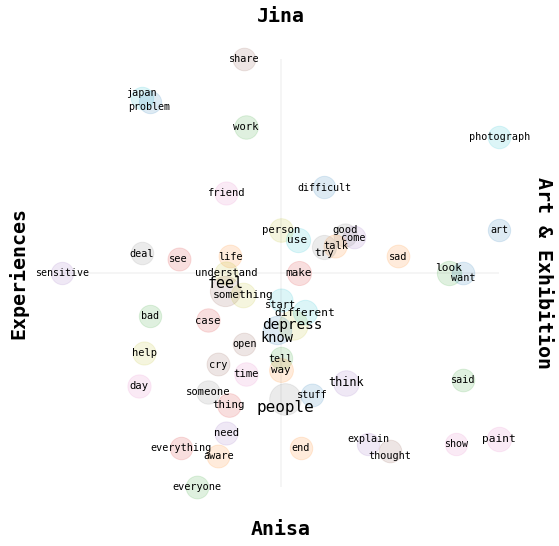

In [119]:
min_count = 10.0
max_count = max(token_counts["Speaker"])

min_ps = 500.0
max_ps = 1000.0

min_fs = 10.0
max_fs = 16.0

text_x_offset = 0.00
text_y_offset_min = 0.00
text_y_offset_max = 0.00

f_family = "monospace"

plt.figure(figsize=[9,9])
for i in range(0,len(topic_df)):
    if token_counts["Speaker"][i] >= min_count:
        
        rel_scale = (token_counts["Speaker"][i]-min_count)/(max_count-min_count)
        
        point_x = topic_df["value"][i]
        point_y = speaker_df["value"][i]
        point_s = min_ps + (max_ps-min_ps)*rel_scale
        
        text_t = token_counts["Token"][i]
        text_s = min_fs + (max_fs-min_fs)*rel_scale
        text_x = topic_df["value"][i]+text_x_offset
        
        if token_counts["Token"][i] in ["good","japan","look","explain","feel"]:
            text_y = speaker_df["value"][i]+(text_y_offset_min+(text_y_offset_max-text_y_offset_min))*rel_scale
            text_valign = "bottom"
        
        elif token_counts["Token"][i] in ["try","want","know","people","thought","problem","start"]:
            text_y = speaker_df["value"][i]-(text_y_offset_min+(text_y_offset_max-text_y_offset_min))*rel_scale
            text_valign = "top"
            
        else:    
            text_y = speaker_df["value"][i]
            text_valign = "center"
            
        plt.scatter(point_x,point_y,point_s,alpha=0.15)
        plt.text(text_x,text_y,text_t,
                 fontsize=text_s,
                 verticalalignment=text_valign, horizontalalignment='center', family=f_family)
        
plt.hlines(y=0.5,xmin=0.0,xmax=1.0, colors='k', alpha=0.05)
plt.vlines(x=0.5,ymin=0.0,ymax=1.0, colors='k', alpha=0.05)

plt.text(0.5, 1.1, "Jina",
         fontsize=20,
         horizontalalignment='center', verticalalignment='center',
         family=f_family, weight="bold")

plt.text(0.5, -0.1, "Anisa",
         fontsize=20,
         horizontalalignment='center', verticalalignment='center',
         family=f_family, weight="bold")

plt.text(-0.1, 0.5, "Experiences",
         fontsize=20,
         horizontalalignment='center', verticalalignment='center',
         family=f_family, weight="bold", rotation=90)

plt.text(1.1, 0.5, "Art & Exhibition",
         fontsize=20,
         horizontalalignment='center', verticalalignment='center',
         family=f_family, weight="bold", rotation=270)

plt.axis('off')
plt.show()

In [120]:
# Getting in the kanji
viz_dict = {"japan": u"日本", "problem": u"問題", "work": u"仕事", "friend": u"友",
            "difficult": u"苦しい", "photograph": u"写真", "art": u"芸術", "good": u"良い", "come": u"来る",
            "talk": u"話す", "try": u"努める", "sad": u"悲しい", "deal": u"扱う", "see": u"覧る",
            "bad": u"悪い", "help": u"助け", "day": u"日", "look": u"観る", "make": u"作る",
            "feel": u"感じ","understand": u"理解","end": "切り","explain": u"説明","thought": u"思考",
            "paint": u"絵","case": u"場合","someone": u"誰か","cry": u"人声","everyone": u"皆","want": u"欲求",
            "tell": u"語る","sensitive": u"敏感","people": u"人たち","life": u"暮らし","share": u"共に",
            "start": u"始め","different": u"別", "need": u"必要","aware": u"気づく","something": u"何か",
            "everything": u"全て","stuff": u"物事","think": u"思い","show": u"見せる","thing": u"物","use": u"利用",
            "open": u"明ける","depress": u"鬱","time": u"時","way": u"仕方", "know": u"知る",
            "person": u"人","said":u"言った"}

token_counts["Kanji"] = token_counts["Token"].apply(lambda x: viz_dict[x] if x in viz_dict.keys() else "none")

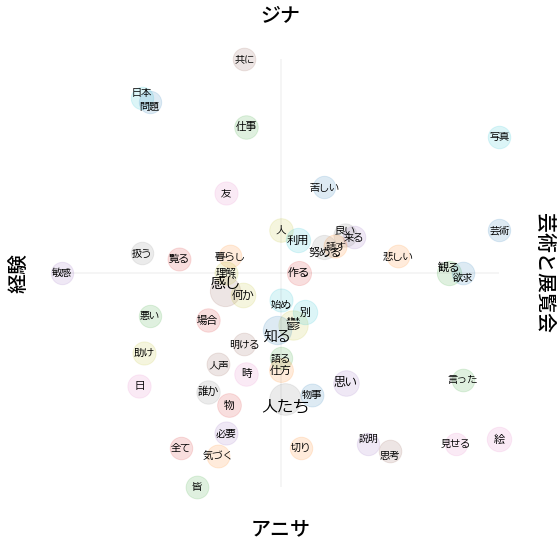

In [125]:
# New viz with kanji
import os
jp_font_1 = fm.FontProperties(fname="/Library/Fonts/Meiryo.ttf")
jp_font_2 = fm.FontProperties(fname="/Library/Fonts/NotoSansJP-Medium.otf")
jp_font_2.set_size(20)

min_count = 10.0
max_count = max(token_counts["Speaker"])

min_ps = 500.0
max_ps = 1000.0

min_fs = 10.0
max_fs = 16.0

text_x_offset = 0.00
text_y_offset_min = 0.00
text_y_offset_max = 0.00

plt.figure(figsize=[9,9])
for i in range(0,len(topic_df)):
    if token_counts["Speaker"][i] >= min_count:
        
        rel_scale = (token_counts["Speaker"][i]-min_count)/(max_count-min_count)
        
        point_x = topic_df["value"][i]
        point_y = speaker_df["value"][i]
        point_s = min_ps + (max_ps-min_ps)*rel_scale
        
        text_t = token_counts["Kanji"][i]
        
        jp_font_1.set_size(min_fs + (max_fs-min_fs)*rel_scale)
        text_x = topic_df["value"][i]+text_x_offset
        #text_y = speaker_df["value"][i]
        #text_valign = "center"
        
        
        if token_counts["Token"][i] in ["good","japan","look","explain","feel"]:
            text_y = speaker_df["value"][i]+(text_y_offset_min+(text_y_offset_max-text_y_offset_min))*rel_scale
            text_valign = "bottom"
        
        elif token_counts["Token"][i] in ["try","want","know","people","thought","problem","start"]:
            text_y = speaker_df["value"][i]-(text_y_offset_min+(text_y_offset_max-text_y_offset_min))*rel_scale
            text_valign = "top"
            
        else:    
            text_y = speaker_df["value"][i]
            text_valign = "center"
            
        plt.scatter(point_x,point_y,point_s,alpha=0.15)
        plt.text(text_x,text_y,text_t,
                 fontsize=text_s,
                 verticalalignment=text_valign, horizontalalignment='center', fontproperties=jp_font_1)
        
plt.hlines(y=0.5,xmin=0.0,xmax=1.0, colors='k', alpha=0.05)
plt.vlines(x=0.5,ymin=0.0,ymax=1.0, colors='k', alpha=0.05)

plt.text(0.5, 1.1, u"ジナ",
         horizontalalignment='center', verticalalignment='center',
         fontproperties=jp_font_2)

plt.text(0.5, -0.1, u"アニサ",
         horizontalalignment='center', verticalalignment='center',
         fontproperties=jp_font_2)

plt.text(-0.1, 0.5, u"経験",
         horizontalalignment='center', verticalalignment='center',
         fontproperties=jp_font_2, rotation=90)

plt.text(1.1, 0.5, u"芸術と展覧会",
         horizontalalignment='center', verticalalignment='center',
         fontproperties=jp_font_2, rotation=270)

plt.axis('off')
plt.show()

In [122]:
# Write out token counts
token_counts[token_counts["Speaker"]>=min_count].to_csv("data/top_tokens.csv")

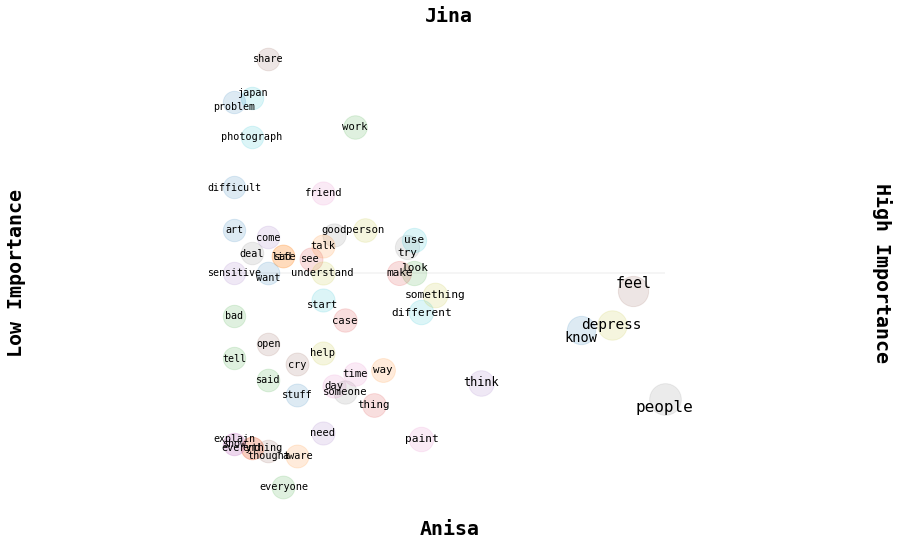

In [111]:
import math
min_count = 10.0
max_count = max(token_counts["Speaker"])

min_x = math.log(min_count,10)
max_x = math.log(max(token_counts["Speaker"]),10)

min_ps = 500.0
max_ps = 1000.0

min_fs = 10.0
max_fs = 16.0

text_x_offset = 0.00
text_y_offset_min = 0.00
text_y_offset_max = 0.00

f_family = "monospace"

plt.figure(figsize=[9,9])
for i in range(0,len(topic_df)):
    if token_counts["Speaker"][i] >= min_count:
        
        rel_scale = (token_counts["Speaker"][i]-min_count)/(max_count-min_count)
        
        point_x = math.log(token_counts["Speaker"][i],10)
        point_y = speaker_df["value"][i]
        point_s = min_ps + (max_ps-min_ps)*rel_scale
        
        text_t = token_counts["Token"][i]
        text_s = min_fs + (max_fs-min_fs)*rel_scale
        text_x = math.log(token_counts["Speaker"][i],10)
        
        if token_counts["Token"][i] in ["good","japan","look","explain","feel"]:
            text_y = speaker_df["value"][i]+(text_y_offset_min+(text_y_offset_max-text_y_offset_min))*rel_scale
            text_valign = "bottom"
        
        elif token_counts["Token"][i] in ["try","want","know","people","thought","problem","start"]:
            text_y = speaker_df["value"][i]-(text_y_offset_min+(text_y_offset_max-text_y_offset_min))*rel_scale
            text_valign = "top"
            
        else:    
            text_y = speaker_df["value"][i]
            text_valign = "center"
        
            
        plt.scatter(point_x,point_y,point_s,alpha=0.15)
        plt.text(text_x,text_y,text_t,
                 fontsize=text_s,
                 verticalalignment=text_valign, horizontalalignment='center', family=f_family)
        
plt.hlines(y=0.5,xmin=min_x,xmax=max_x, colors='k', alpha=0.05)
#plt.vlines(x=0.5,ymin=0.0,ymax=1.0, colors='k', alpha=0.05)

plt.text(min_x+(max_x - min_x)/2, 1.1, "Jina",
         fontsize=20,
         horizontalalignment='center', verticalalignment='center',
         family=f_family, weight="bold")

plt.text(min_x+(max_x - min_x)/2, -0.1, "Anisa",
         fontsize=20,
         horizontalalignment='center', verticalalignment='center',
         family=f_family, weight="bold")

plt.text(min_x-0.5, 0.5, "Low Importance",
         fontsize=20,
         horizontalalignment='center', verticalalignment='center',
         family=f_family, weight="bold", rotation=90)

plt.text(max_x+0.5, 0.5, "High Importance",
         fontsize=20,
         horizontalalignment='center', verticalalignment='center',
         family=f_family, weight="bold", rotation=270)

plt.axis('off')
plt.show()

In [99]:
math.log2(98)

6.614709844115208

## Balancing the Bias
Technically we could use the word frequency distributions at this point. However, I want to make sure that Jina and Anisa have equal input in the model. So what I'm going to do is intra-scale the frequency distributions.

### Wait, Intra-Scale?
Intra-scale is the name I gave to a two-step scaling method I developed and used in my research. I wanted to analyse a platform process used by a cell-line to express different products. The challenge was that the different products affected the cells differently so it was difficult to separate the impact of the process and product on the cell's performance. This is called confounding, and confound it all, it can be a major issue!

In [230]:
jina_token_count = len(tokens_df[tokens_df["Speaker"]=="Jina"])
anisa_token_count = len(tokens_df[tokens_df["Speaker"]=="Anisa"])

jina_unique_token_count = len(set(tokens_df[tokens_df["Speaker"]=="Jina"]["Token"].tolist()))
anisa_unique_token_count = len(set(tokens_df[tokens_df["Speaker"]=="Anisa"]["Token"].tolist()))

print(jina_token_count)
print(anisa_token_count)

print(jina_unique_token_count)
print(anisa_unique_token_count)

1247
1875
502
661


In [231]:
tokens_df.to_csv("temp_analysis.csv")

# Old Way

In [104]:
# Merging similar topics to simplify visualisation
conversations.Topic = conversations.Topic.apply(lambda x: "Experiences" if "Victories" in x else x)
conversations.Topic = conversations.Topic.apply(lambda x: "Experiences" if "Experiences" in x else "Art and Exhibition")
#conversations.Topic = conversations.Topic.apply(lambda x: "Experiences" if "Victories" in x else x)

topics = list(set(conversations.Topic))

jina = conversations[conversations["Speaker"]=="Jina"]
anisa = conversations[conversations["Speaker"]=="Anisa"]
conv = jina.append(anisa)

jina_dict = {}
anisa_dict = {}
conv_dict = {}

for topic in topics:
    jina_dict[topic] = verbatimFreq(jina[jina.Topic==topic]["Verbatim"].to_list())
    anisa_dict[topic] = verbatimFreq(anisa[anisa.Topic==topic]["Verbatim"].to_list())
    conv_dict[topic] = verbatimFreq(conv[conv.Topic==topic]["Verbatim"].to_list())

Art and Exhibition


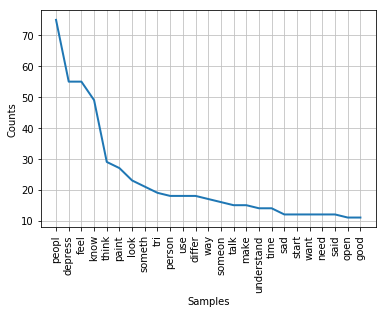

Experiences


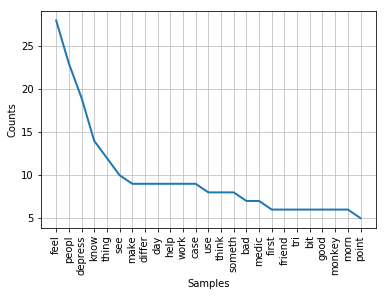

In [105]:
for topic in topics:
    print(topic)
    conv_dict[topic].plot(25)

## Balancing the Bias
Technically we could use the word frequency distributions at this point. However, I want to make sure that Jina and Anisa have equal input in the model. So what I'm going to do is intra-scale the frequency distributions.

### Wait, Intra-Scale?
Intra-scale is the name I gave to a two-step scaling method I developed and used in my research. I wanted to analyse a platform process used by a cell-line to express different products. The challenge was that the different products affected the cells differently so it was difficult to separate the impact of the process and product on the cell's performance. This is called confounding, and confound it all, it can be a major issue!

In [123]:
# Convert to dataframes
pd.DataFrame.from_dict(dict(jina_dict[topic]))

ValueError: If using all scalar values, you must pass an index

,topic,key,freq


In [58]:
# Convert to dictionaries and cross-scale.
jina_dict_scaled = {}
anisa_dict_scaled = {}

for topic in topics:
    jina_dict_scaled[topic] = dict(jina_dict[topic])
    jina_token_count = float(sum(jina_dict_scaled[topic].values()))
    for key in jina_dict_scaled[topic]:
        jina_dict_scaled[topic][key] = float(jina_dict_scaled[topic][key])/jina_token_count
    
    anisa_dict_scaled[topic] = dict(anisa_dict[topic])
    anisa_token_count = float(sum(anisa_dict_scaled[topic].values()))
    for key in anisa_dict_scaled[topic]:
        anisa_dict_scaled[topic][key] = float(anisa_dict_scaled[topic][key])/anisa_token_count

In [59]:
conv_dict_scaled = {}
conv_dict_array = []

for topic in topics:
    conv_dict_scaled[topic] = dict(conv_dict[topic])
    conv_token_count = float(sum(conv_dict_scaled[topic].values()))
    
    for key in conv_dict_scaled[topic]:
        if key in anisa_dict_scaled[topic].keys():
            anisa_value = anisa_dict_scaled[topic][key]
        else:
            anisa_value = 0.0
        
        if key in jina_dict_scaled[topic].keys():
            jina_value = jina_dict_scaled[topic][key]
        else:
            jina_value = 0.0
            
        conv_dict_scaled[topic][key] = {"topic": topic,
                                        "key": key,
                                        "conv_value": jina_value+anisa_value,
                                        "jina_share": jina_value/(jina_value+anisa_value),
                                        "anisa_share": anisa_value/(jina_value+anisa_value)}
        conv_dict_array.append((topic,
                               key,
                               jina_value+anisa_value,
                               jina_value/(jina_value+anisa_value),
                               anisa_value/(jina_value+anisa_value)))
                               
conv_tokens_df = pd.DataFrame.from_records(conv_dict_array,
                                           columns=["topic","key","conv_value","jina_share","anisa_share"])

In [7]:
art_tokens = conv_tokens_df[(conv_tokens_df["topic"]=="Art") & ((conv_tokens_df["jina_share"]!=1.0) & (conv_tokens_df["anisa_share"]!=1.0))]
exp_tokens = conv_tokens_df[(conv_tokens_df["topic"]=="Experiences") & ((conv_tokens_df["jina_share"]!=1.0) & (conv_tokens_df["anisa_share"]!=1.0))]
exh_tokens = conv_tokens_df[(conv_tokens_df["topic"]=="Exhibition")  & ((conv_tokens_df["jina_share"]!=1.0) & (conv_tokens_df["anisa_share"]!=1.0))]

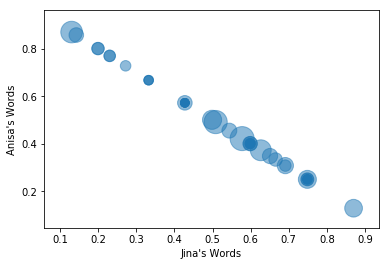

63


,topic,key,conv_value,jina_share,anisa_share
598,Art,look,0.057875,0.577709,0.422291
562,Art,feel,0.053832,0.508165,0.491835
552,Art,paint,0.046812,0.129860,0.870140
573,Art,depress,0.043649,0.626720,0.373280
592,Art,think,0.036567,0.498730,0.501270


In [8]:
plt.scatter(art_tokens["jina_share"], art_tokens["anisa_share"], s=art_tokens["conv_value"]*10000, alpha=0.5)
plt.xlabel("Jina's Words")
plt.ylabel("Anisa's Words")
plt.show()
print(len(art_tokens))
art_tokens.sort_values("conv_value", ascending=False).head()

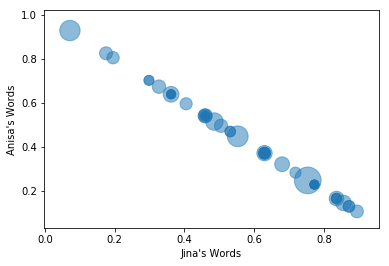

78


,topic,key,conv_value,jina_share,anisa_share
959,Experiences,feel,0.071275,0.753857,0.246143
929,Experiences,depress,0.043179,0.553062,0.446938
1026,Experiences,peopl,0.041582,0.071788,0.928212
951,Experiences,know,0.030715,0.485934,0.514066
962,Experiences,thing,0.024745,0.361905,0.638095


In [9]:
plt.scatter(exp_tokens["jina_share"], exp_tokens["anisa_share"], s=exp_tokens["conv_value"]*10000, alpha=0.5)
plt.xlabel("Jina's Words")
plt.ylabel("Anisa's Words")
plt.show()
print(len(exp_tokens))
exp_tokens.sort_values("conv_value", ascending=False).head()

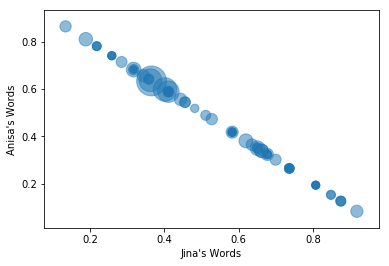

131


,topic,key,conv_value,jina_share,anisa_share
24,Exhibition,peopl,0.089045,0.365367,0.634633
28,Exhibition,know,0.055430,0.401594,0.598406
0,Exhibition,depress,0.052005,0.362188,0.637812
36,Exhibition,feel,0.045863,0.410696,0.589304
179,Exhibition,someon,0.021591,0.317225,0.682775


In [10]:
plt.scatter(exh_tokens["jina_share"], exh_tokens["anisa_share"], s=exh_tokens["conv_value"]*10000, alpha=0.5)
plt.xlabel("Jina's Words")
plt.ylabel("Anisa's Words")
plt.show()
print(len(exh_tokens))
exh_tokens.sort_values("conv_value", ascending=False).head()

In [11]:
top_tokens = art_tokens.sort_values("conv_value",ascending=False).iloc[0:5,:].append(
    exp_tokens.sort_values("conv_value",ascending=False).iloc[0:5,:].append(
        exh_tokens.sort_values("conv_value",ascending=False).iloc[0:5,:]))

In [12]:
top_tokens.to_csv("top_tokens.csv")

In [46]:
help(pd.DataFrame.pivot_table)

Help on function pivot_table in module pandas.core.frame:

pivot_table(self, values=None, index=None, columns=None, aggfunc='mean', fill_value=None, margins=False, dropna=True, margins_name='All')
    Create a spreadsheet-style pivot table as a DataFrame. The levels in
    the pivot table will be stored in MultiIndex objects (hierarchical
    indexes) on the index and columns of the result DataFrame.
    
    Parameters
    ----------
    values : column to aggregate, optional
    index : column, Grouper, array, or list of the previous
        If an array is passed, it must be the same length as the data. The
        list can contain any of the other types (except list).
        Keys to group by on the pivot table index.  If an array is passed,
        it is being used as the same manner as column values.
    columns : column, Grouper, array, or list of the previous
        If an array is passed, it must be the same length as the data. The
        list can contain any of the other type

In [47]:
all_tokens = art_tokens.append(exp_tokens.append(exh_tokens))
len(all_tokens)

272

In [50]:
all_tokens.pivot_table(values="conv_value", index="key", columns="topic")

topic,Art,Exhibition,Experiences
key,,,
accept,NaN,NaN,0.007725
admit,NaN,0.004653,NaN
advic,NaN,0.007855,NaN
almost,0.007113,NaN,NaN
alon,NaN,0.005398,NaN
alreadi,0.005076,NaN,NaN
anoth,0.005076,NaN,NaN
anyth,NaN,0.004169,NaN
around,0.007113,0.002941,0.006494
